In [33]:
# Libraries for general data management
import pandas as pd
import numpy  as np
np.seterr(divide = 'ignore') 

# Libraries for creating and validating models
from sklearn.linear_model    import LinearRegression
from sklearn.metrics         import mean_squared_error
from sklearn.model_selection import LeaveOneOut, cross_val_predict, cross_val_score

# Libraries for data visualization
import matplotlib.pyplot  as plt
import matplotlib.patches as mpatches
import seaborn as sns
plt.rc("figure", figsize=(14,7))
plt.rc("font", size=12)

# Libraries for data modeling
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Library for iterations
from itertools import combinations

# Helper functions

# Input file path (can be also an excel)
DATA_PATH = './data/data_merged.ods'

In [2]:
data = pd.read_excel(DATA_PATH, skiprows=[0], na_values=['-'])

In [3]:
# We rename some columns for having an easier reference
data.rename(columns = {'Calcined kaolinite content (%)':'Kaolinite_content'}, inplace = True)
data.rename(columns = {'Dv,50 (µm)':'Dv50'                                 }, inplace = True)
data.rename(columns = {'BET Specific surface (m2/g)':'BET_specific_surface'}, inplace = True)

data.rename(columns = {'1D'  : 'day_1'}, inplace = True)
data.rename(columns = {'3D': 'day_3'}, inplace = True)
data.rename(columns = {'7D': 'day_7'}, inplace = True)
data.rename(columns = {'28D':'day_28'}, inplace = True)
data.rename(columns = {'90D':'day_90'}, inplace = True)

data.rename(columns = {'STD'  : 'STD_1D'}, inplace = True)
data.rename(columns = {'STD.1': 'STD_3D'}, inplace = True)
data.rename(columns = {'STD.2': 'STD_7D'}, inplace = True)
data.rename(columns = {'STD.3':'STD_28D'}, inplace = True)
data.rename(columns = {'STD.4':'STD_90D'}, inplace = True)

# Sorting allows us to plot functions more easily
data = data.sort_values('Kaolinite_content')
data

,Clay,day_1,STD_1D,day_3,STD_3D,day_7,STD_7D,day_28,STD_28D,day_90,...,CaO,MgO,SO3,Na2O,K2O,TiO2,P2O5,MnO,Others,LOI
0,B45 Quartz B250,7.808750,0.251891,18.683750,0.328841,26.073438,0.696464,29.168750,0.541867,30.062500,...,NaN,NaN,NaN,NaN,0.100000,NaN,NaN,NaN,NaN,0.10000
44,Iran G2,11.934375,0.384489,21.492282,0.384489,27.876247,0.861786,34.715457,1.842897,35.720665,...,0.527174,0.467391,0.197826,1.107609,3.463043,1.652174,0.755435,NaN,0.760870,0.73913
19,Holcim 3 U.S.,8.479688,0.294320,20.914062,0.126797,28.031250,0.754776,36.659375,1.178679,38.145313,...,7.719000,2.641000,0.576000,0.370000,2.637000,0.631000,0.224000,NaN,0.160000,1.04000
13,South Africa,9.387500,0.260358,19.310938,0.414056,26.745313,0.406823,33.459375,0.971274,34.284375,...,0.055000,1.126000,NaN,0.556000,3.785000,0.920000,NaN,NaN,NaN,3.76000
57,Guat 4,8.459375,0.039775,19.987500,0.141421,30.690625,0.004419,42.446875,0.950175,NaN,...,2.574358,2.452426,0.020145,1.559671,1.673121,0.995602,0.117691,0.173886,0.004241,1.20000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,Newchem,15.739062,0.398806,40.104687,1.729149,47.618750,1.716381,56.648438,1.757376,60.450000,...,NaN,0.070000,NaN,0.090000,NaN,1.803000,NaN,NaN,0.100000,1.00000
5,B45 India1 750°C,13.183750,0.566334,30.173750,0.726647,52.091250,1.006780,64.031250,4.819113,63.318750,...,0.100000,0.100000,NaN,0.100000,0.100000,2.400000,0.100000,NaN,0.200000,1.00000
10,Imerys 3%,20.751562,0.390925,42.773438,1.566299,55.651562,2.685301,65.831250,1.629377,65.610417,...,NaN,NaN,NaN,NaN,0.060000,2.278000,NaN,NaN,NaN,2.02000
11,Imerys 2%,16.714063,0.560096,43.670313,1.400933,51.946875,0.332701,57.267187,2.402090,60.501562,...,NaN,NaN,NaN,NaN,0.060000,2.278000,NaN,NaN,NaN,2.02000


In [4]:
data_d1 = data[["Kaolinite_content", "day_1", "STD_1D"]]
data_d1.dropna()

X = data_d1["Kaolinite_content"].values
Y1  = data_d1["day_1"].values
weights1 = data_d1["STD_1D"].values

#print(X, X.shape)
#print(Y1, Y1.shape)
#print(weights1, weights1.shape)

mod_wls = sm.WLS(Y1, X, weights=weights1, method='nm')
res_wls = mod_wls.fit()
print(res_wls.summary())

                                 WLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.883
Model:                            WLS   Adj. R-squared (uncentered):              0.881
Method:                 Least Squares   F-statistic:                              491.5
Date:                Tue, 08 Dec 2020   Prob (F-statistic):                    5.16e-32
Time:                        04:39:34   Log-Likelihood:                            -inf
No. Observations:                  66   AIC:                                        inf
Df Residuals:                      65   BIC:                                        inf
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

parameters OLS vs. WLS
[0.21969557]
[0.21720739]


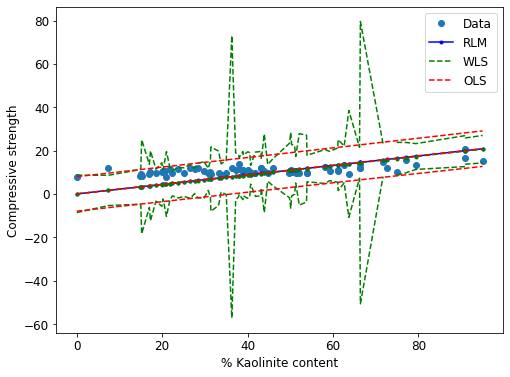

In [43]:
# plot WLS
prstd, iv_l, iv_u = wls_prediction_std(res_wls)

fig, ax = plt.subplots(figsize=(8,6))

#Datapoints
ax.plot(X, Y1, 'o', label="Data")

# RLM prediction
resrlm = sm.RLM(Y1, X).fit()
ax.plot(X, resrlm.fittedvalues, 'b.-', label="RLM")

# WLS prediction
ax.plot(X, res_wls.fittedvalues, 'g--.')
ax.plot(X, iv_u, 'g--', label="WLS")
ax.plot(X, iv_l, 'g--')
ax.set_xlabel('% Kaolinite content')
ax.set_ylabel('Compressive strength')

# Now let's try to compare it with an OLS
res_ols = sm.OLS(Y1, X).fit()
print("======================")
print("parameters OLS vs. WLS")
print("======================")
print(res_ols.params)
print(res_wls.params)

# Calculate prediction interval
tppf = stats.t.ppf(0.975, res_ols.df_resid)
prstd_ols, iv_l_ols, iv_u_ols = wls_prediction_std(res_ols)

ax.plot(X, res_ols.fittedvalues, 'r--')
ax.plot(X, iv_u_ols, 'r--', label="OLS")
ax.plot(X, iv_l_ols, 'r--')

ax.legend(loc="best");

Now we will try it again but applying the variance as weight instead of the standard deviation. This is instead of inputting as weights the STD_1D, STD_3D, etc.; we will input the STD_1D^2, STD_3D^2, etc.

In [6]:
weights1_2 = data_d1["STD_1D"].values**2
# print(weights1, weights1_2)

mod_wls_2 = sm.WLS(Y1, X, weights=weights1_2, method='nm')
res_wls_2 = mod_wls.fit()
print(res_wls.summary())

                                 WLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.883
Model:                            WLS   Adj. R-squared (uncentered):              0.881
Method:                 Least Squares   F-statistic:                              491.5
Date:                Tue, 08 Dec 2020   Prob (F-statistic):                    5.16e-32
Time:                        04:39:34   Log-Likelihood:                            -inf
No. Observations:                  66   AIC:                                        inf
Df Residuals:                      65   BIC:                                        inf
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

parameters OLS vs. WLS
[0.21969557]
[0.21720739]


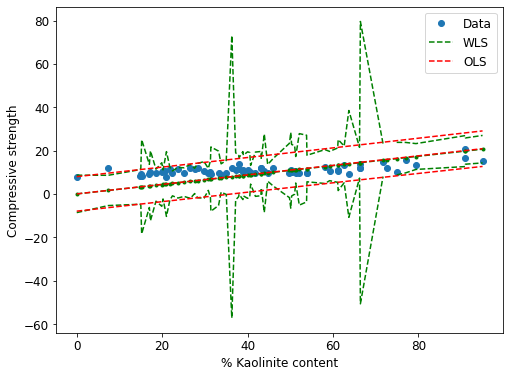

In [7]:
# plot WLS
prstd, iv_l, iv_u = wls_prediction_std(res_wls_2)

fig, ax = plt.subplots(figsize=(8,6))

#Datapoints
ax.plot(X, Y1, 'o', label="Data")

# WLS prediction
ax.plot(X, res_wls_2.fittedvalues, 'g--.')
ax.plot(X, iv_u, 'g--', label="WLS")
ax.plot(X, iv_l, 'g--')
ax.set_xlabel('% Kaolinite content')
ax.set_ylabel('Compressive strength')

# Now let's try to compare it with an OLS
res_ols = sm.OLS(Y1, X).fit()
print("======================")
print("parameters OLS vs. WLS")
print("======================")
print(res_ols.params)
print(res_wls.params)

# Calculate prediction interval
tppf = stats.t.ppf(0.975, res_ols.df_resid)
prstd_ols, iv_l_ols, iv_u_ols = wls_prediction_std(res_ols)

ax.plot(X, res_ols.fittedvalues, 'r--')
ax.plot(X, iv_u_ols, 'r--', label="OLS")
ax.plot(X, iv_l_ols, 'r--')

ax.legend(loc="best");

It dis not make sense to put the variance as we obtain exorbitant values. Let's make a comparison of the days taking into account the standard deviation only. But first let's remove the datapoints with a very large standard deviation.

In [8]:
## subplots de todos los días aquí
# data without outliers

data_wo_ol = data[(data["STD_1D"]<4) | (data["STD_3D"]<4) | (data["STD_7D"]<4) | (data["STD_28D"]<4) | (data["STD_90D"]<4) ]
data_wo_ol

,Clay,day_1,STD_1D,day_3,STD_3D,day_7,STD_7D,day_28,STD_28D,day_90,...,CaO,MgO,SO3,Na2O,K2O,TiO2,P2O5,MnO,Others,LOI
0,B45 Quartz B250,7.808750,0.251891,18.683750,0.328841,26.073438,0.696464,29.168750,0.541867,30.062500,...,NaN,NaN,NaN,NaN,0.100000,NaN,NaN,NaN,NaN,0.10000
44,Iran G2,11.934375,0.384489,21.492282,0.384489,27.876247,0.861786,34.715457,1.842897,35.720665,...,0.527174,0.467391,0.197826,1.107609,3.463043,1.652174,0.755435,NaN,0.760870,0.73913
19,Holcim 3 U.S.,8.479688,0.294320,20.914062,0.126797,28.031250,0.754776,36.659375,1.178679,38.145313,...,7.719000,2.641000,0.576000,0.370000,2.637000,0.631000,0.224000,NaN,0.160000,1.04000
13,South Africa,9.387500,0.260358,19.310938,0.414056,26.745313,0.406823,33.459375,0.971274,34.284375,...,0.055000,1.126000,NaN,0.556000,3.785000,0.920000,NaN,NaN,NaN,3.76000
57,Guat 4,8.459375,0.039775,19.987500,0.141421,30.690625,0.004419,42.446875,0.950175,NaN,...,2.574358,2.452426,0.020145,1.559671,1.673121,0.995602,0.117691,0.173886,0.004241,1.20000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,Newchem,15.739062,0.398806,40.104687,1.729149,47.618750,1.716381,56.648438,1.757376,60.450000,...,NaN,0.070000,NaN,0.090000,NaN,1.803000,NaN,NaN,0.100000,1.00000
5,B45 India1 750°C,13.183750,0.566334,30.173750,0.726647,52.091250,1.006780,64.031250,4.819113,63.318750,...,0.100000,0.100000,NaN,0.100000,0.100000,2.400000,0.100000,NaN,0.200000,1.00000
10,Imerys 3%,20.751562,0.390925,42.773438,1.566299,55.651562,2.685301,65.831250,1.629377,65.610417,...,NaN,NaN,NaN,NaN,0.060000,2.278000,NaN,NaN,NaN,2.02000
11,Imerys 2%,16.714063,0.560096,43.670313,1.400933,51.946875,0.332701,57.267187,2.402090,60.501562,...,NaN,NaN,NaN,NaN,0.060000,2.278000,NaN,NaN,NaN,2.02000


In [24]:
# function to create all the models
datas = {}

for day in [1,3,7,28,90]:
    datas[f"day_{day}"] = data_wo_ol[["Kaolinite_content", f"day_{day}", f"STD_{day}D"]]
    datas[f"day_{day}"] = datas[f"day_{day}"].dropna()

    datas[f"X{day}"] = datas[f"day_{day}"]["Kaolinite_content"].values
    datas[f"Y{day}"] = datas[f"day_{day}"][f"day_{day}"].values
    datas[f"weight{day}"] = datas[f"day_{day}"][f"STD_{day}D"].values

    datas[f"mod_wls_{day}"] = sm.WLS(datas[f"Y{day}"], datas[f"X{day}"], weights=datas[f"weight{day}"])
    datas[f"res_wls_{day}"] = datas[f"mod_wls_{day}"].fit()
    print(datas[f"res_wls_{day}"].summary())

                                 WLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.883
Model:                            WLS   Adj. R-squared (uncentered):              0.881
Method:                 Least Squares   F-statistic:                              491.5
Date:                Tue, 08 Dec 2020   Prob (F-statistic):                    5.16e-32
Time:                        04:45:49   Log-Likelihood:                            -inf
No. Observations:                  66   AIC:                                        inf
Df Residuals:                      65   BIC:                                        inf
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

parameters OLS vs. WLS
[0.21969557]
[0.21720739]
parameters OLS vs. WLS
[0.51255273]
[0.48957374]
parameters OLS vs. WLS
[0.78432047]
[0.75831165]
parameters OLS vs. WLS
[0.98709882]
[0.91814005]
parameters OLS vs. WLS
[1.00456923]
[0.97229355]


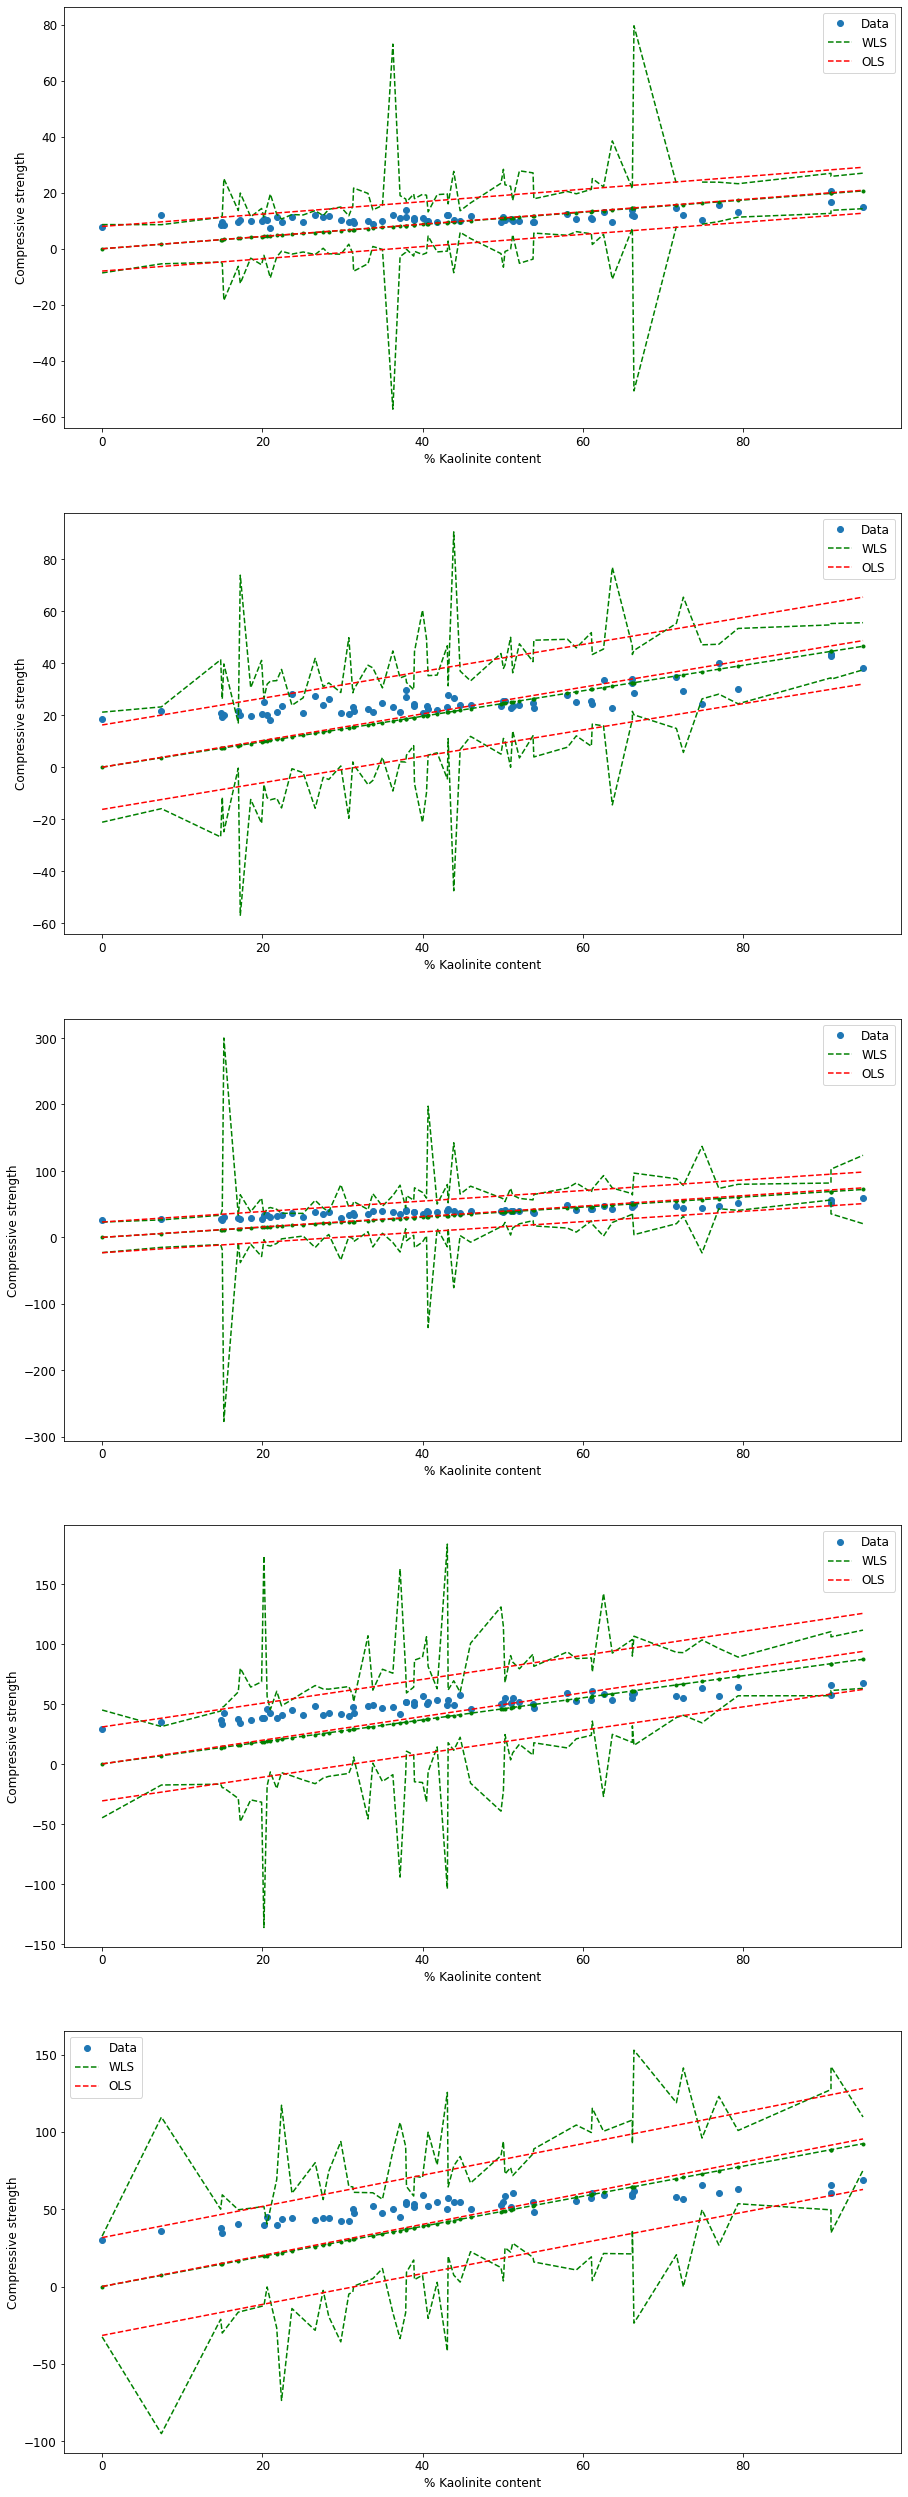

In [25]:
# plot WLS
fig, axs = plt.subplots(5, 1, figsize=(15,45))

for i, day in enumerate([1,3,7,28,90]):
    datas[f"prstd{day}"], datas[f"iv_l{day}"], datas[f"iv_u{day}"] = wls_prediction_std(datas[f"res_wls_{day}"])

    #Datapoints
    axs[i].plot(datas[f"X{day}"], datas[f"Y{day}"], 'o', label="Data")

    # WLS prediction
    axs[i].plot(datas[f"X{day}"], datas[f"res_wls_{day}"].fittedvalues, 'g--.')
    axs[i].plot(datas[f"X{day}"], datas[f"iv_u{day}"], 'g--', label="WLS")
    axs[i].plot(datas[f"X{day}"], datas[f"iv_l{day}"], 'g--')
    axs[i].set_xlabel('% Kaolinite content')
    axs[i].set_ylabel('Compressive strength')

    # Now let's try to compare it with an OLS
    datas[f"res_ols_{day}"] = sm.OLS(datas[f"Y{day}"], datas[f"X{day}"]).fit()
    print("======================")
    print("parameters OLS vs. WLS")
    print("======================")
    print(datas[f"res_ols_{day}"].params)
    print(datas[f"res_wls_{day}"].params)

    # Calculate prediction interval
    tppf = stats.t.ppf(0.975, datas[f"res_ols_{day}"].df_resid)
    datas[f"prstd_ols{day}"], datas[f"iv_l_ols{day}"], datas[f"iv_u_ols{day}"] = wls_prediction_std(datas[f"res_ols_{day}"])

    axs[i].plot(datas[f"X{day}"], datas[f"res_ols_{day}"].fittedvalues, 'r--')
    axs[i].plot(datas[f"X{day}"], datas[f"iv_u_ols{day}"], 'r--', label="OLS")
    axs[i].plot(datas[f"X{day}"], datas[f"iv_l_ols{day}"], 'r--')

    axs[i].legend(loc="best");


# Modelling STD only

We will try to see if there is a relation and with which values in the STDs given by the first proposed dataset.

In [11]:
def create_name_and_formula(day, variables):
    name = f"STD_{i}D_{len(variables)}vars_"+"_".join(variables)
    formula = f"STD_{day}D ~ "
    equals = "+".join(variables)
    return [name, formula+equals]

def get_model_r2_adj(formula, df):
    mods = smf.ols(formula=formula, data=df)
    res = mods.fit()
    return res.rsquared_adj

def get_model(day, variables, df):
    name, formula = create_name_and_formula(day, variables)
    df_nmv = df.copy()
    varrr = [f"STD_{day}D"] + variables
    df_nmv = df_nmv[varrr]
    df_nmv = df_nmv.dropna()
    df_nmv = (df_nmv-df_nmv.min())/(df_nmv.max()-df_nmv.min())
    mods = smf.ols(formula=formula, data=df_nmv)
    res = mods.fit()
    return mods, res

In [12]:
data.columns

Index(['Clay', 'day_1', 'STD_1D', 'day_3', 'STD_3D', 'day_7', 'STD_7D',
       'day_28', 'STD_28D', 'day_90', 'STD_90D', 'Origin of clay',
       'Calcination', 'Kaolinite_content', 'Dv50', 'D10', 'D90', 'Span (-)',
       'BET_specific_surface', 'SiO2', 'Al2O3', 'Fe2O3', 'CaO', 'MgO', 'SO3',
       'Na2O', 'K2O', 'TiO2', 'P2O5', 'MnO', 'Others', 'LOI'],
      dtype='object')

In [13]:
data_clean = data[['Kaolinite_content', 'Dv50', 'BET_specific_surface', 'Al2O3', 'Fe2O3', 'CaO', 'MgO', 'K2O', 'TiO2']]

In [14]:
cols = data_clean.columns.values

bestAdjR2s = {}
bestCombs = {}

# Max number of variables for the model
maxnvars = len(cols)

# Try all combinations
for i in [1, 3, 7, 28, 90]:
    bestAdjR2 = -1
    bestComb = ''
    # Try combinations of 1, 2, ..., maxnvars variables
    for j in range(1,maxnvars+1):
        for vararr in combinations(cols, j):
            df_nmv = data.copy()
            varrr = [f"STD_{i}D"] + list(vararr)
            df_nmv = df_nmv[varrr]
            df_nmv = df_nmv.dropna()
            df_nmv = (df_nmv-df_nmv.min())/(df_nmv.max()-df_nmv.min())
            name, formula = create_name_and_formula(i, vararr)
            r2 = get_model_r2_adj(formula, df_nmv)
            if(r2>bestAdjR2): 
                bestAdjR2 = r2
                bestComb = name
            #print(formula+":"+str(r2))
    bestAdjR2s[f"STD_{i}D"] = bestAdjR2
    bestCombs[f"STD_{i}D"]= bestComb

bestAdjR2s, bestCombs

({'STD_1D': 0.2895281031117908,
  'STD_3D': 0.20176383511662765,
  'STD_7D': 0.16730527157579078,
  'STD_28D': 0.18968605412491657,
  'STD_90D': 0.13896299546699586},
 {'STD_1D': 'STD_1D_8vars_Kaolinite_content_Dv50_BET_specific_surface_Al2O3_Fe2O3_CaO_MgO_TiO2',
  'STD_3D': 'STD_3D_1vars_Kaolinite_content',
  'STD_7D': 'STD_7D_3vars_Dv50_BET_specific_surface_TiO2',
  'STD_28D': 'STD_28D_4vars_Dv50_BET_specific_surface_Al2O3_TiO2',
  'STD_90D': 'STD_90D_5vars_Dv50_BET_specific_surface_Fe2O3_CaO_K2O'})

We can see that the maximum adjusted R squared is 0.2895. However, this happens when we model the data with 8 variables. This is probably overfitting even if the adjusted R-squared is penalizing the use of more variables. Additionally, we can appriciate how, the score decreases with the time. This makes sense since we have less datapoints for those days. For this reason, because this method does not give us a lot of information, we can deduce that there is not a way to model with a linear model. 
That said, we can appreciate a larger influence of Kaolinite content in the standard deviation for during the first dates. After that the "Dv50", "BET_specific_surface", and "TiO2" are the ones that appear in almost every model.

Let's see what happens when we limit the combinations to 3 variables as a way to get a more robust model and avoid overfitting. 

In [15]:
# Max number of variables for the model
maxnvars = 3

# Try all combinations
for i in [1, 3, 7, 28, 90]:
    bestAdjR2 = -1
    bestComb = ''
    # Try combinations of 1, 2, ..., maxnvars variables
    for j in range(1,maxnvars+1):
        for vararr in combinations(cols, j):
            df_nmv = data.copy()
            varrr = [f"STD_{i}D"] + list(vararr)
            df_nmv = df_nmv[varrr]
            df_nmv = df_nmv.dropna()
            df_nmv = (df_nmv-df_nmv.min())/(df_nmv.max()-df_nmv.min())
            name, formula = create_name_and_formula(i, vararr)
            r2 = get_model_r2_adj(formula, df_nmv)
            if(r2>bestAdjR2): 
                bestAdjR2 = r2
                bestComb = name
            #print(formula+":"+str(r2))
    bestAdjR2s[f"STD_{i}D"] = bestAdjR2
    bestCombs[f"STD_{i}D"]= bestComb

bestAdjR2s, bestCombs

({'STD_1D': 0.15473110489958197,
  'STD_3D': 0.20176383511662765,
  'STD_7D': 0.16730527157579078,
  'STD_28D': 0.18739708007225597,
  'STD_90D': 0.10656429445897586},
 {'STD_1D': 'STD_1D_3vars_BET_specific_surface_CaO_TiO2',
  'STD_3D': 'STD_3D_1vars_Kaolinite_content',
  'STD_7D': 'STD_7D_3vars_Dv50_BET_specific_surface_TiO2',
  'STD_28D': 'STD_28D_3vars_Kaolinite_content_Dv50_BET_specific_surface',
  'STD_90D': 'STD_90D_2vars_CaO_K2O'})

As espected we get a lower but more realistic score. This confirms that, in general, the r-squared is too low to take it into account. 

We could try to plot them results to see if it follows another kind of nonlinear model.

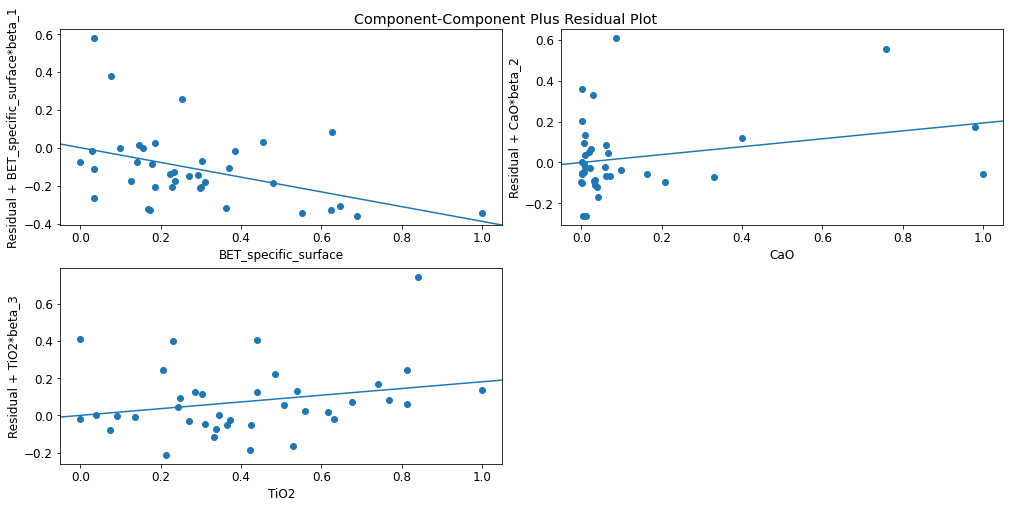

In [16]:
# STD_1D_3vars_BET_specific_surface_CaO_TiO2
features_1D = ["BET_specific_surface", "CaO", "TiO2"]

mod_1D, res_1D = get_model(1, features_1D, data)

fig_1D = sm.graphics.plot_ccpr_grid(res_1D)
fig_1D.tight_layout(pad=0.5)

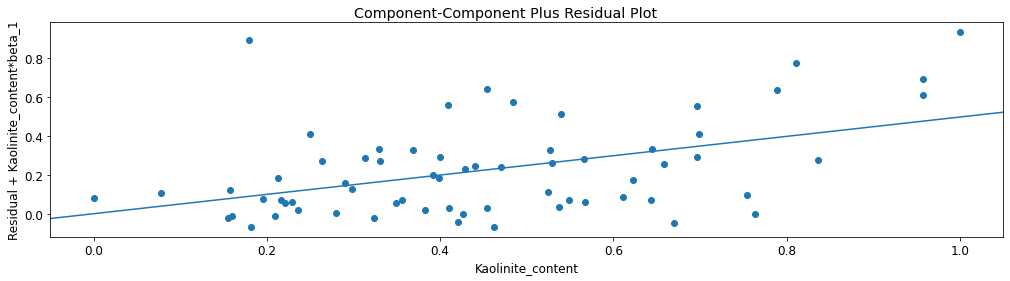

In [26]:
# STD_3D_1vars_Kaolinite_content
features_3D = ["Kaolinite_content"]

mod_3D, res_3D = get_model(3, features_3D, data)

fig_3D = sm.graphics.plot_ccpr_grid(res_3D)
fig_3D.tight_layout(pad=0.5)

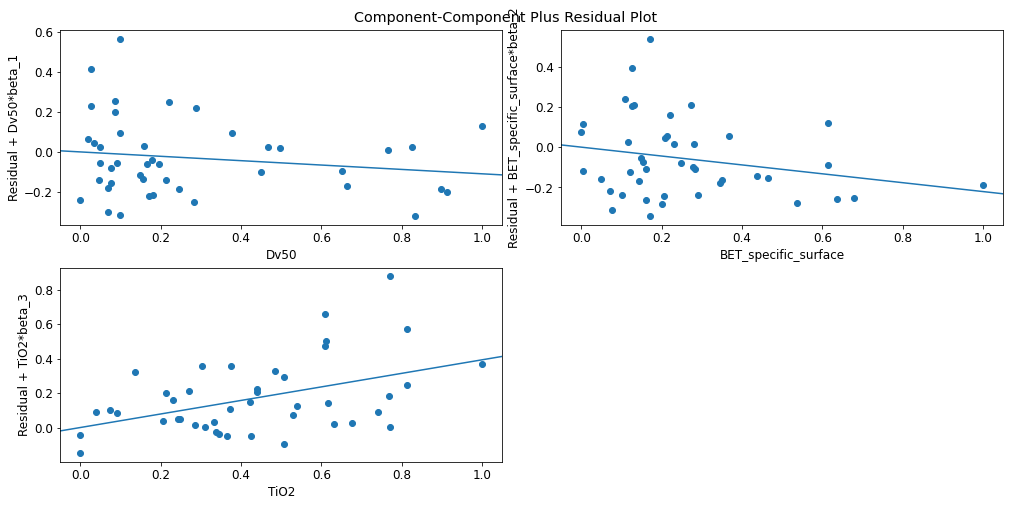

In [18]:
# STD_7D_3vars_Dv50_BET_specific_surface_TiO2
features_7D = ["Dv50", "BET_specific_surface", "TiO2"]

mod_7D, res_7D = get_model(7, features_7D, data)

fig_7D = sm.graphics.plot_ccpr_grid(res_7D)
fig_7D.tight_layout(pad=0.5)

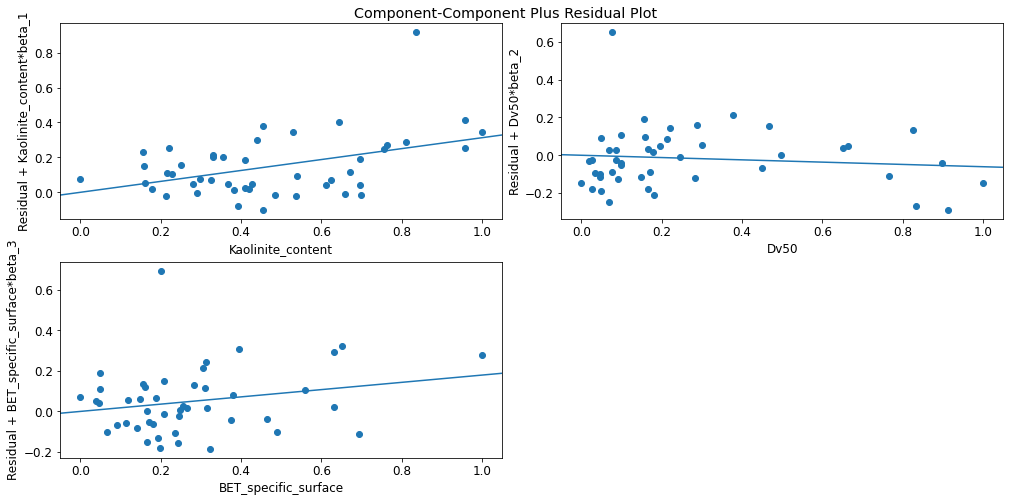

In [19]:
# 'STD_28D': 'STD_28D_3vars_Kaolinite_content_Dv50_BET_specific_surface',
features_28D = ["Kaolinite_content", "Dv50", "BET_specific_surface"]

mod_28D, res_28D = get_model(28, features_28D, data)

fig_28D = sm.graphics.plot_ccpr_grid(res_28D)
fig_28D.tight_layout(pad=0.5)

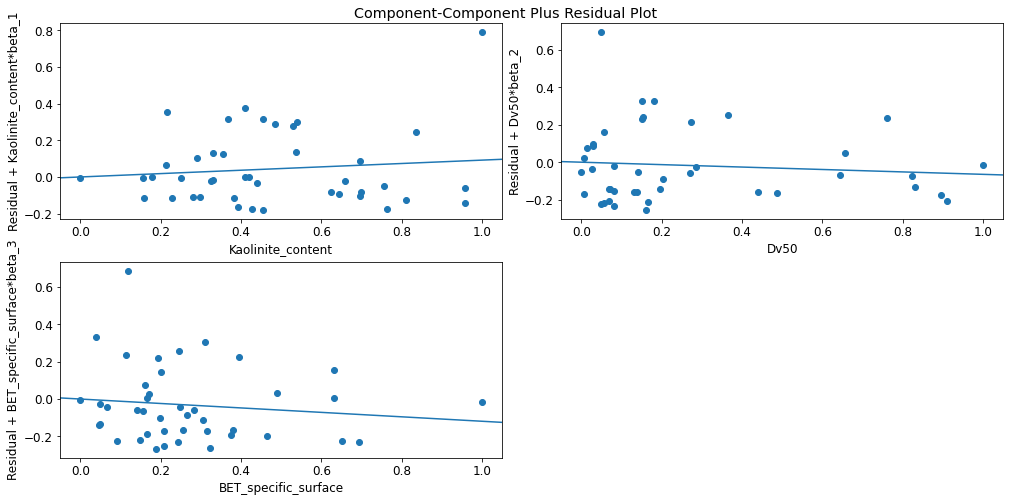

In [28]:
# 'STD_90D': 'STD_90D_2vars_CaO_K2O'
features_90D = ["Kaolinite_content", "Dv50", "BET_specific_surface"]

mod_90D, res_90D = get_model(90, features_90D, data)

fig_90D = sm.graphics.plot_ccpr_grid(res_90D)
fig_90D.tight_layout(pad=0.5)

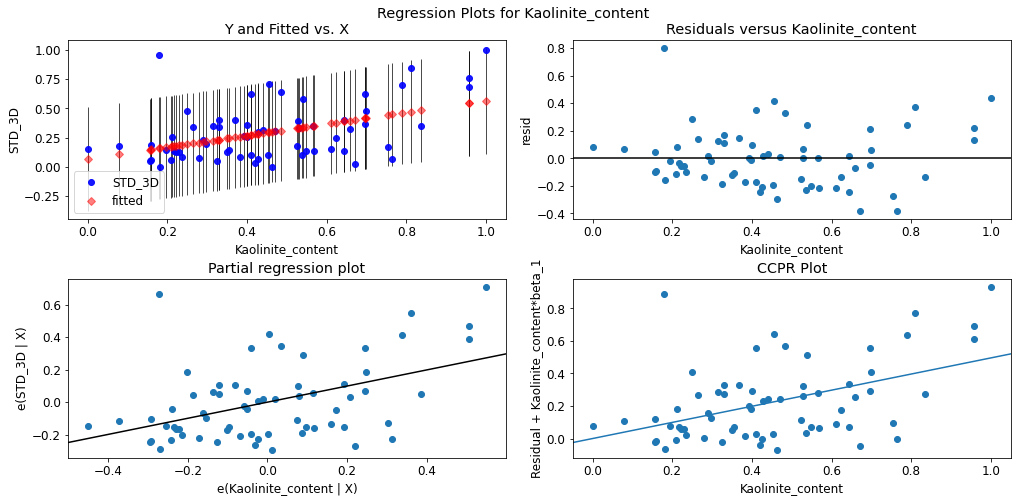

In [29]:
# To visualize more information on day 3 (only one variable) let's 
# build more possibly valuable and informative plots

fig_3D_bis = sm.graphics.plot_regress_exog(res_3D, "Kaolinite_content")
fig_3D_bis.tight_layout(pad=0.5)

This 2x2 plot contains the dependent variable and fitted values with confidence intervals vs. the independent variable chosen, the residuals of the model vs. the chosen independent variable, a partial regression plot, and a CCPR plot. *This function can be used for quickly checking modeling assumptions with respect to a single regressor.* [1]


No day does seems to be following any polynomial trajectory
Another approach we could carry out would be to model the data taking the "days" as variables.

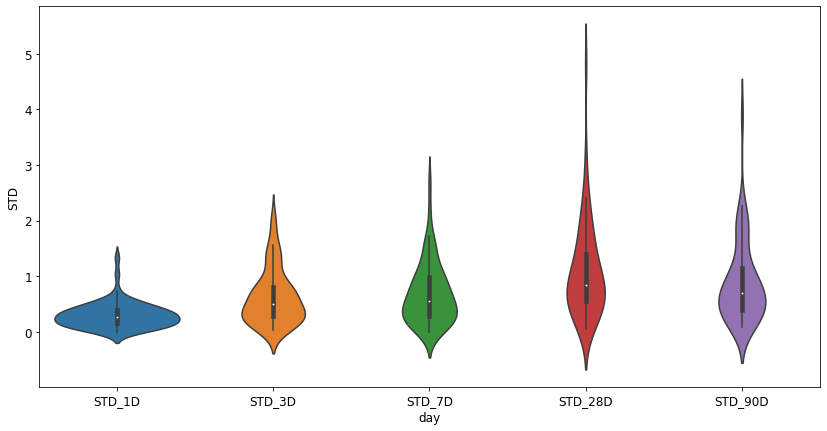

In [36]:
melted_data = pd.melt(data, id_vars=['Clay'], value_vars=['STD_1D','STD_3D','STD_7D','STD_28D','STD_90D'], var_name='day', value_name='STD')
ax = sns.violinplot(x="day", y="STD", data=melted_data)
#plt.plot

<AxesSubplot:>

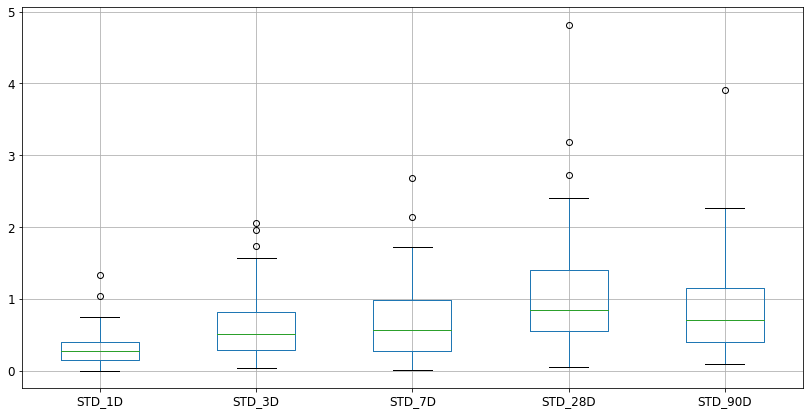

In [39]:
# If we plot it with boxplots we will see the outliers with more detail

data.boxplot(column=['STD_1D', 'STD_3D', 'STD_7D', 'STD_28D', 'STD_90D'])

Can we create a model with 7 values?

In [82]:
data_quantiles = melted_data.copy()
data_quantiles["days"] = np.zeros(330)
data_quantiles["days"][data_quantiles["day"]=="STD_1D"] = 1
data_quantiles["days"][data_quantiles["day"]=="STD_3D"] = 3
data_quantiles["days"][data_quantiles["day"]=="STD_7D"] = 7
data_quantiles["days"][data_quantiles["day"]=="STD_28D"] = 28
data_quantiles["days"][data_quantiles["day"]=="STD_90D"] = 90
data_quantiles

<ipython-input-82-2f35c29979d7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_quantiles["days"][data_quantiles["day"]=="STD_1D"] = 1
<ipython-input-82-2f35c29979d7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_quantiles["days"][data_quantiles["day"]=="STD_3D"] = 3
<ipython-input-82-2f35c29979d7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_quantiles["days"][data_quantiles["day"]=="STD_7D"] = 7
<ipython-input-8

,Clay,day,STD,days
0,B45 Quartz B250,STD_1D,0.251891,1.0
1,Iran G2,STD_1D,0.384489,1.0
2,Holcim 3 U.S.,STD_1D,0.294320,1.0
3,South Africa,STD_1D,0.260358,1.0
4,Guat 4,STD_1D,0.039775,1.0
...,...,...,...,...
325,Newchem,STD_90D,0.407402,90.0
326,B45 India1 750°C,STD_90D,1.785445,90.0
327,Imerys 3%,STD_90D,0.635362,90.0
328,Imerys 2%,STD_90D,0.327529,90.0


In [115]:
mod = smf.quantreg('STD ~ days', data_quantiles)
res = mod.fit(q=.5)
print(res.summary())

                         QuantReg Regression Results                          
Dep. Variable:                    STD   Pseudo R-squared:              0.03568
Model:                       QuantReg   Bandwidth:                      0.3513
Method:                 Least Squares   Sparsity:                        1.128
Date:                Tue, 08 Dec 2020   No. Observations:                  319
Time:                        05:56:46   Df Residuals:                      317
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4143      0.039     10.546      0.000       0.337       0.492
days           0.0046      0.001      4.595      0.000       0.003       0.007


In [116]:
# Visualizing Quantiles
quantiles = np.arange(.05, .96, .1)
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['days']] + res.conf_int().loc['days'].tolist()

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])

ols = smf.ols('STD ~ days', data_quantiles).fit()
ols_ci = ols.conf_int().loc['days'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['days'],
           lb = ols_ci[0],
           ub = ols_ci[1])

print(models)
print(ols)

      q         a         b        lb        ub
0  0.05  0.052227  0.000746 -0.000494  0.001987
1  0.15  0.148172  0.001861  0.000396  0.003325
2  0.25  0.211429  0.002319  0.000672  0.003966
3  0.35  0.299236  0.003374  0.001635  0.005114
4  0.45  0.377770  0.004150  0.002253  0.006048
5  0.55  0.492285  0.003925  0.001811  0.006040
6  0.65  0.636647  0.004936  0.002296  0.007576
7  0.75  0.731880  0.009373  0.006215  0.012532
8  0.85  1.053427  0.009413  0.005230  0.013596
9  0.95  1.661839  0.007791  0.003405  0.012178
{'a': 0.5965832569853864, 'b': 0.004583669904234722, 'lb': 0.002397946311163071, 'ub': 0.0067693934973063735}


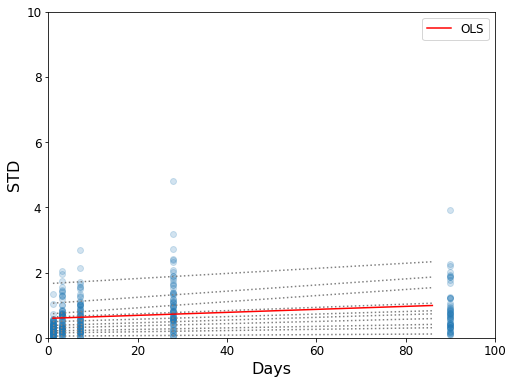

In [117]:
x = np.arange(data_quantiles.days.min(), data_quantiles.days.max(), 85)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', color='grey')

y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')
ax.scatter(data_quantiles.days, data_quantiles.STD, alpha=.2)
ax.set_xlim((0, 100))
ax.set_ylim((0, 10))
legend = ax.legend()
ax.set_xlabel('Days', fontsize=16)
ax.set_ylabel('STD', fontsize=16);

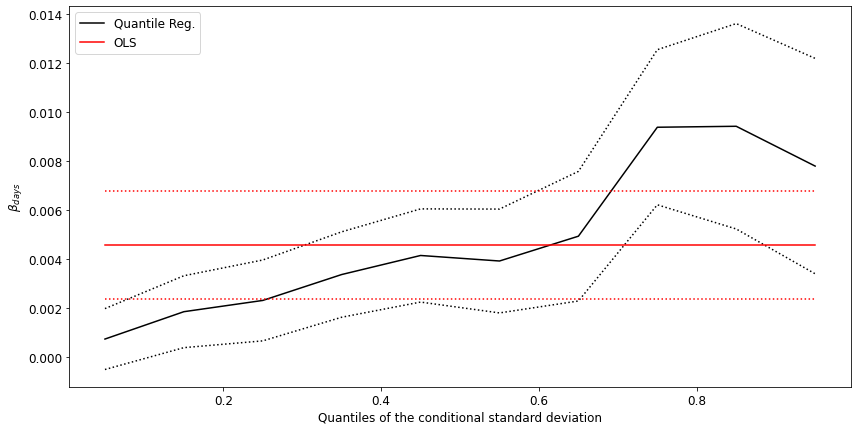

In [106]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color='black', label='Quantile Reg.')
p2 = plt.plot(models.q, models.ub, linestyle='dotted', color='black')
p3 = plt.plot(models.q, models.lb, linestyle='dotted', color='black')
p4 = plt.plot(models.q, [ols['b']] * n, color='red', label='OLS')
p5 = plt.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
p6 = plt.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
plt.ylabel(r'$\beta_{days}$')
plt.xlabel('Quantiles of the conditional standard deviation')
plt.legend()
plt.show()

### References:

[1] https://www.statsmodels.org/devel/examples